In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Outlier Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df[df['industry']=='机械设备']
df7=pd.read_csv('data/stock_k_data(2023_09_01).csv')[['code','open','volume']]
df7.rename(columns={
    'open': 'open_91',
    'volume': 'volume_91'
}, inplace=True)
df=pd.merge(df,df7,on='code')
df['open_dif']=df['open']-df['open_91']
df['volume_dif']=df['volume']-df['volume_91']
df=df.dropna().reset_index(drop=True)

In [3]:
columns_outliers=['npMargin', 'netProfit', 'epsTTM', 'totalShare','liqaShare','YOYEquity','MBRevenue','YOYNI',
       'YOYEPSBasic', 'liabilityToAsset', 'currentRatio', 'assetToEquity',
       'YOYLiability', 'dupontAssetTurn','open_dif','volume_dif']
X_ = df[columns_outliers]
scaler = StandardScaler()
X_ = pd.DataFrame(scaler.fit_transform(X_),columns = X_.columns)

In [4]:
def remove_outliers(series):
    mean = series.mean()
    std = series.std()
    threshold = 3  # 可调整阈值
    return abs(series - mean) <= threshold * std
outliers=X_[-X_.apply(remove_outliers).all(axis=1)]

In [5]:
outliers.head()

,npMargin,netProfit,epsTTM,totalShare,liqaShare,YOYEquity,MBRevenue,YOYNI,YOYEPSBasic,liabilityToAsset,currentRatio,assetToEquity,YOYLiability,dupontAssetTurn,open_dif,volume_dif
0,0.052482,4.666889,0.065960,4.436826,5.331868,-0.139263,4.801935,0.119521,0.110988,0.660528,-0.355057,0.120463,-0.585396,-0.037685,-0.343551,-3.159566
2,-3.324665,-1.127806,-0.954613,0.422482,0.465936,-1.088176,-0.174905,-7.647510,-7.508712,1.616119,-0.882625,1.199490,-0.270544,-1.613488,0.004074,0.218887
4,-3.097150,-0.450614,-0.775535,-0.149350,-0.100951,-0.894683,-0.259169,0.105037,0.087866,-0.473563,-0.260187,-0.407905,-0.847071,-0.997861,0.055363,0.552042
19,-0.120107,-0.147172,-0.328927,0.112109,0.209606,-0.176696,-0.041154,0.247818,0.234012,-0.989742,0.023745,-0.550970,-0.431038,3.076295,0.011672,1.449376
21,-1.699488,-3.168499,-5.668831,-0.116499,-0.061930,-2.903676,0.540863,-0.085540,-0.106090,2.150150,-0.637891,2.764446,-0.394726,0.518384,0.002174,0.283474


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


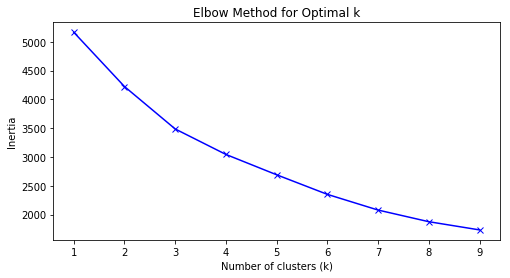

In [6]:
# 使用肘部法则选择适当的聚类数目
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(outliers)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(outliers)
outliers['Cluster'] = kmeans.labels_

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


d:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
d:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
d:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

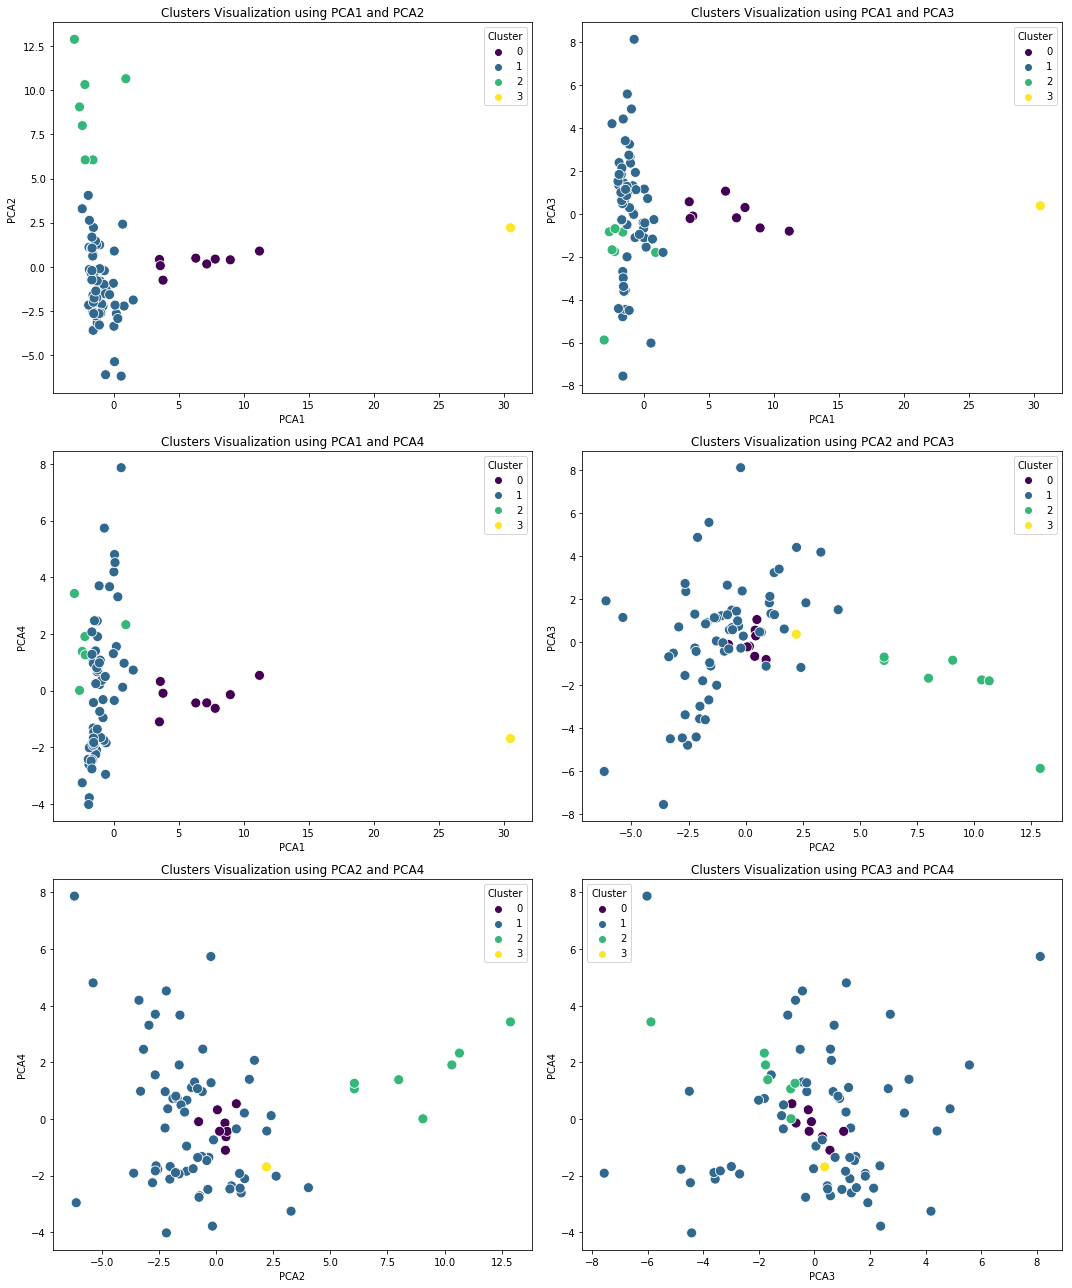

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
# 假设 scaled_outlier 已经存在且已预处理

# 执行PCA生成4个组件
pca = PCA(n_components=4)
pca_data = pca.fit_transform(outliers.drop(columns=['Cluster']))
outliers['PCA1'] = pca_data[:, 0]
outliers['PCA2'] = pca_data[:, 1]
outliers['PCA3'] = pca_data[:, 2]
outliers['PCA4'] = pca_data[:, 3]

# 生成所有两两组合的图
combinations_of_pca = list(combinations(['PCA1', 'PCA2', 'PCA3','PCA4'], 2))

# 设置绘图的子图网格大小
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 遍历所有组合并绘制子图
for (ax, (pca_x, pca_y)) in zip(axes.flatten(), combinations_of_pca):
    sns.scatterplot(data=outliers, x=pca_x, y=pca_y, hue='Cluster', palette='viridis', s=100, ax=ax)
    ax.set_title(f'Clusters Visualization using {pca_x} and {pca_y}')

# 调整子图布局
plt.tight_layout()
plt.show()

In [9]:
components = pca.components_

# 打印PCA1和PCA2的成分
print("PCA1 components:\n", components[0])
print("PCA2 components:\n", components[1])
print("PCA3 components:\n", components[2])
print("PCA4 components:\n", components[3])

PCA1 components:
 [ 6.10425932e-02  4.74442145e-01  3.55594214e-02  5.00437640e-01
  4.92290279e-01 -3.95521146e-04  5.03468482e-01  6.72262000e-02
  6.04936280e-02  3.35480378e-02 -5.96972431e-02 -1.41940088e-02
 -2.90927565e-02  2.96128770e-02 -4.65627064e-02 -8.17607625e-02]
PCA2 components:
 [-0.32172193 -0.09804633 -0.28184699  0.10246741  0.11466488 -0.27137301
  0.05242254 -0.55947206 -0.56760492  0.13872017 -0.17351902  0.09383435
 -0.00736093 -0.09205284  0.0451772  -0.05911769]
PCA3 components:
 [-0.19073835 -0.06792012 -0.29499858  0.00986606  0.0109618   0.10689128
  0.00851782  0.25835295  0.26337918  0.34177659 -0.49109281  0.48719651
 -0.02267231  0.08805367  0.26541209  0.22382148]
PCA4 components:
 [ 0.19218049  0.05775596  0.45714285 -0.05363696 -0.05683489  0.44148993
 -0.0346145  -0.21319697 -0.2241986   0.20816621 -0.27806698  0.31628964
  0.25038062  0.15755255 -0.34999779 -0.14869246]


In [10]:
for j in range(4):
    indices = [i for i, x in enumerate(components[j]) if abs(x) > 0.3]
    weight=[x for i, x in enumerate(components[j]) if abs(x) > 0.3]
    print(indices,weight)
    selected_columns = outliers.columns[indices]
    result_table = pd.DataFrame({'Selected "Columns': selected_columns})
    print(result_table)

[1, 3, 4, 6] [0.47444214452973626, 0.5004376399220921, 0.4922902794372178, 0.5034684819457477]
  Selected "Columns
0         netProfit
1        totalShare
2         liqaShare
3         MBRevenue
[0, 7, 8] [-0.32172192944145384, -0.559472064766454, -0.5676049241515263]
  Selected "Columns
0          npMargin
1             YOYNI
2       YOYEPSBasic
[9, 10, 11] [0.34177658609532746, -0.49109281326287485, 0.48719650958267086]
  Selected "Columns
0  liabilityToAsset
1      currentRatio
2     assetToEquity
[2, 5, 11, 14] [0.457142853200778, 0.4414899301569479, 0.31628963811435334, -0.3499977944804421]
  Selected "Columns
0            epsTTM
1         YOYEquity
2     assetToEquity
3          open_dif


PCA1：净利润(+)、总股本(+)、流通股本(+)、主营营业收入(+) (代表了总体量)\
PCA2：销售净利率(-)、净利润同比增长率(-)、基本每股收益同比增长率(-) （代表经营不善，收益减少）\
PCA3：资产负债率(+)、流动比率(-)、权益乘数(+) (负债程度高、融资面广) \
PCA4: 每股收益(+)、净资产同比增长率(+)、权益乘数(+)、本季度股价上涨(-)  （）


In [11]:
# 获取解释方差
explained_variance = pca.explained_variance_

# 获取解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 输出结果
for i, (var, ratio) in enumerate(zip(explained_variance, explained_variance_ratio), start=1):
    print(f"主成分{i}: 解释方差 = {var:.4f}, 解释方差比例 = {ratio:.4f}")

主成分1: 解释方差 = 18.4759, 解释方差比例 = 0.2861
主成分2: 解释方差 = 11.7350, 解释方差比例 = 0.1817
主成分3: 解释方差 = 6.7387, 解释方差比例 = 0.1043
主成分4: 解释方差 = 5.2864, 解释方差比例 = 0.0818


In [12]:
df8=pd.read_csv('data/stock_k_data(2024_04_01).csv')[['code','open','volume']]
df8.rename(columns={
    'open': 'open_41',
    'volume': 'volume_41'
}, inplace=True)
selected_result=pd.merge(df,df8,on='code')
selected_result['open_diff_4_1']=selected_result['open_41']-selected_result['open']

In [13]:
big_company_index=outliers[(outliers['PCA1']>10)].index

In [14]:
selected_result.loc[big_company_index][['code_name','open_diff_4_1']]

,code_name,open_diff_4_1
41,中国中车,1.57
194,徐工机械,0.94


In [34]:
potential_company_index=outliers[(outliers['PCA3']<-0.5)&(outliers['PCA2']<-2)&(outliers['PCA4']>0)].index

In [36]:
selected_result.loc[potential_company_index][['code_name','open_diff_4_1']]


,code_name,open_diff_4_1
74,浙江鼎力,6.12
141,石头科技,62.63
157,铂力特,-34.80
172,高测股份,-7.99
422,浩洋股份,7.60


In [37]:
selected_result[selected_result['open_diff_4_1']>0]

,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,...,industry,open,volume,open_91,volume_91,open_dif,volume_dif,open_41,volume_41,open_diff_4_1
0,sh.600031,0.062907,4.606157e+09,7.152143e+10,0.533542,8.485740e+09,8.464216e+09,0.045954,0.053388,0.041606,...,机械设备,13.79,36039073.0,15.55,86565385.0,-1.76,-50526312.0,14.65,106193654.0,0.86
7,sh.600320,0.019632,6.465446e+08,3.274229e+10,0.098699,5.268354e+09,3.321998e+09,0.038770,0.428571,0.081970,...,机械设备,3.32,16222174.0,3.50,22961853.0,-0.18,-6739679.0,3.40,44735416.0,0.08
13,sh.600499,0.269006,2.608190e+09,9.687547e+09,1.073689,1.948420e+09,1.948420e+09,0.000875,-0.508748,-0.498636,...,机械设备,10.51,9916754.0,10.10,4535515.0,0.41,5381239.0,10.55,24251624.0,0.04
17,sh.600528,0.058642,1.763180e+09,2.982999e+10,0.784954,2.221552e+09,2.221552e+09,0.053381,-0.063291,-0.067946,...,机械设备,7.44,11810474.0,8.66,10451329.0,-1.22,1359145.0,7.59,18724676.0,0.15
20,sh.600560,0.058274,5.533530e+07,9.345259e+08,0.234773,2.236455e+08,2.236455e+08,0.045037,0.192893,0.153865,...,机械设备,14.79,6585602.0,13.25,2159400.0,1.54,4426202.0,16.20,9298200.0,1.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,sz.300818,0.089105,8.355864e+07,9.377585e+08,0.762503,1.050131e+08,6.255614e+07,0.057992,-0.405861,-0.382284,...,机械设备,33.04,774450.0,29.05,1195100.0,3.99,-420650.0,35.00,5957295.0,1.96
422,sz.300833,0.283070,3.693757e+08,1.304894e+09,4.342316,8.432700e+07,5.353631e+07,0.086891,0.028080,0.025413,...,机械设备,90.10,204800.0,103.33,106800.0,-13.23,98000.0,97.70,463852.0,7.60
446,sz.300988,0.056885,8.684243e+07,1.526626e+09,0.656503,1.402974e+08,5.774900e+07,0.227643,0.047619,0.042199,...,机械设备,21.18,5956716.0,19.97,2032356.0,1.21,3924360.0,28.04,37104751.0,6.86
456,sz.301030,0.062525,2.152567e+08,3.442722e+09,1.508196,1.436466e+08,1.145083e+08,0.624115,1.123288,1.196365,...,机械设备,41.40,4334100.0,51.12,2812163.0,-9.72,1521937.0,55.00,4101134.0,13.60


In [38]:
selected_result.loc[outliers.index][selected_result['open_diff_4_1']>1][['code_name','open_diff_4_1']]

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,code_name,open_diff_4_1
22,天地科技,1.61
41,中国中车,1.57
64,赛腾股份,3.28
66,杭叉集团,2.87
74,浙江鼎力,6.12
120,中国通号,1.29
141,石头科技,62.63
142,时代电气,11.56
191,中集集团,1.93
192,中联重科,1.70
